# ECMM416DA (Learning From Data) - Coursework

In [552]:
!pip list

176987.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Package           Version
----------------- -----------
appnope           0.1.4
asttokens         2.4.1
comm              0.2.2
contourpy         1.2.1
cycler            0.12.1
debugpy           1.8.2
decorator         5.1.1
executing         2.0.1
fonttools         4.53.1
imbalanced-learn  0.12.3
ipykernel         6.29.5
ipython           8.26.0
jedi              0.19.1
joblib            1.4.2
jupyter_client    8.6.2
jupyter_core      5.7.2
kiwisolver        1.4.5
matplotlib        3.9.1
matplotlib-inline 0.1.7
nest-asyncio      1.6.0
numpy             2.0.1
packaging         24.1
pandas            2.2.2
parso             0.8.4
pexpect           4.9.0
pillow            10.4.0
pip               24.1.2
platformdirs      4.2.2
prompt_toolkit    3.0.47
psutil            6.0.0
ptyprocess        0.7.0
pure_eval         0.2.3
Pygments          2.18.0
pyparsing         3.1.2
python-dateutil   2.9.0.post0
pytz              2024.1
pyzmq             26.0.3
scikit-learn      1.5.1
scipy          

In [553]:
# All packages used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

For this assignment, the Online Shoppers Purchasing Intention Dataset is investigated.  It is provided as a csv file which is loaded below.

There will be overlap between this notebook and the written report as I believe that it is important to tell a story through the processing in the notebook.

Research question: Can the purchase intention be predicted using logistic regression or decision tree models?

Models: Logistic regression, decision tree

In [554]:
data = pd.read_csv('online_shoppers_intention.csv')
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


## Data Exploration and Cleaning

In this section I evaluate each column in the data and decide if it should move on to be processed in the feature engineering section.

The data set contains 18 columns related to various aspects of the shoppers behavior:
* Administrative
* Administrative_Duration
* Informational
* Informational_Duration
* ProductRelated
* ProductRelated_Duration
* BounceRates
* ExitRates
* PageValues
* SpecialDay
* Month
* OperatingSystems
* Browser
* Region
* TrafficType
* VisitorType
* Weekend
* Revenue

Each of the 12,330 rows represents a single shopping session in which a user has visited the website.

### Output Classification

The column which indicates if there was a purchase in the session is called 'Revenue'.

In [555]:
def plot_bar(data, column):
    total = len(data)

    fig, ax = plt.subplots()

    sns.countplot(x=column, data=data, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

    # add annotations
    for c in ax.containers:
        labels = [f'{h/data[column].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')

    plt.show()

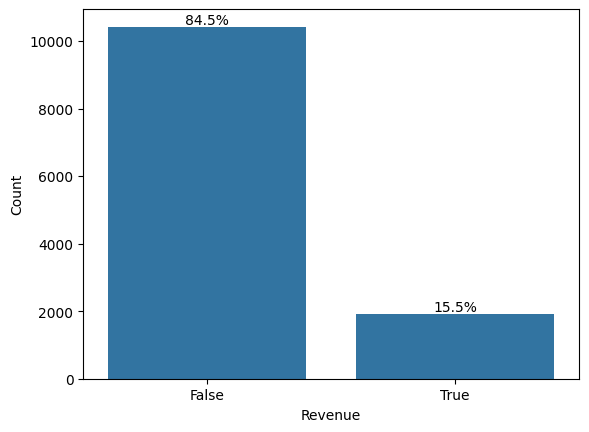

In [556]:
plot_bar(data, 'Revenue')

As you would expect, the majority of sessions do not have a purchase.  To ensure that any models are trained well, the dataset should be leveled through a process such as over/undersampling.

### Pages Visited

There are 6 columns related to the type of page visited on the website.  Administrative, Informational and ProductRelated are counts for the type of page. Administrative_Duration, Informational_Duration and ProductRelated_Duration are the time spent on each type of page.

The column pairs such as Administrative and Administrative_Duration are quite similar conceptually, so it is worth checking if there is a correlation between them.

In [557]:
def print_column_correlation(column_1, column_2):
    correlation = data[column_1].corr(data[column_2])
    print(f"{column_1}, {column_2} correlation: " + str(correlation))

In [558]:
# Print correlations
print_column_correlation('Administrative', 'Administrative_Duration')
print_column_correlation('Informational', 'Informational_Duration')
print_column_correlation('ProductRelated', 'ProductRelated_Duration')

Administrative, Administrative_Duration correlation: 0.6015833421250232
Informational, Informational_Duration correlation: 0.618954861781457
ProductRelated, ProductRelated_Duration correlation: 0.8609268361763696


In [559]:
def plot_scatter(data, x_name, x_units, y_name, y_units, mean=False):
    x_data = data[x_name]
    y_data = data[y_name]

    fig = plt.figure()
    ax1 = fig.add_subplot()  
    ax1.scatter(x_data, y_data, label='Data Points')
    if mean:
        mean_points = data.groupby(x_name)[y_name].transform('mean')
        ax1.scatter(x_data, mean_points, label='Mean')
        plt.legend()
    ax1.set_xlabel(x_name + ' ' + x_units)
    ax1.set_ylabel(y_name + ' ' + y_units)
    plt.title(x_name + ' vs ' + y_name)
    plt.show()

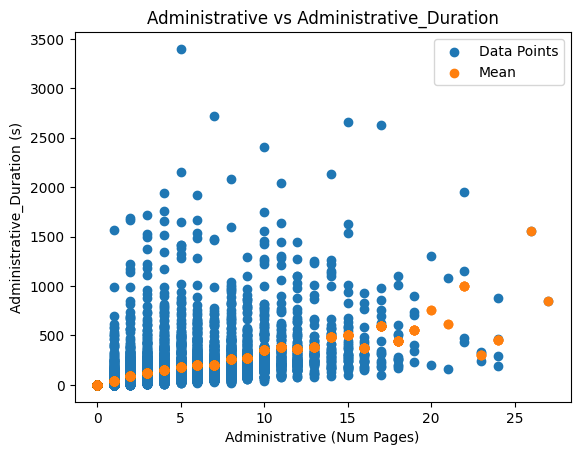

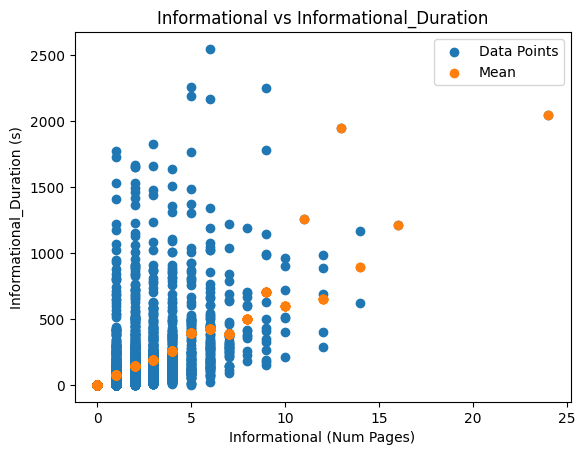

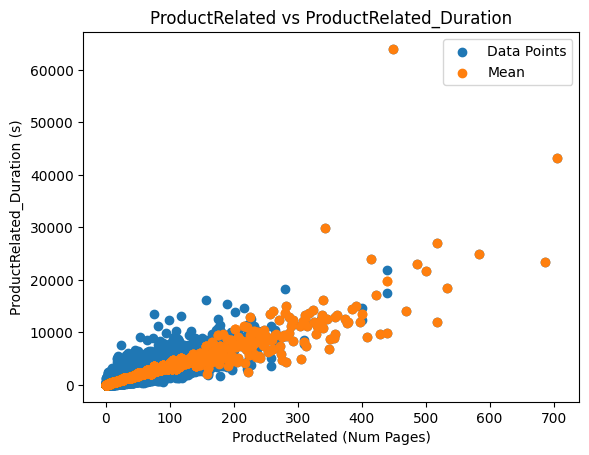

In [560]:
# Data scatter plots with the mean for each x value
plot_scatter(data, 'Administrative', '(Num Pages)', 'Administrative_Duration', '(s)',True)
plot_scatter(data, 'Informational', '(Num Pages)', 'Informational_Duration', '(s)',True)
plot_scatter(data, 'ProductRelated', '(Num Pages)', 'ProductRelated_Duration', '(s)',True)

As you would expect from simple intuition there is some correlation between each pair where as the number of pages visited increases, the time spent also increases.  However, the correlation is not strong enough to exclude any columns (would want a value of at least 0.9).

Next, the distribution of each column is plotted.

In [561]:
def plot_2_hist(data, column_1, column_2, bins):
    fig, (ax0, ax1) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

    ax0.hist(data[column_1], bins)
    ax1.hist(data[column_2], bins)
    ax0.set_xlabel(column_1)
    ax0.set_ylabel('Count')
    ax1.set_xlabel(column_2)
    ax1.set_ylabel('Count')

    fig.tight_layout()
    plt.show()
    print(f'{column_1} skew: ' + str(data[column_1].skew()))
    print(f'{column_2} skew: ' + str(data[column_2].skew()))

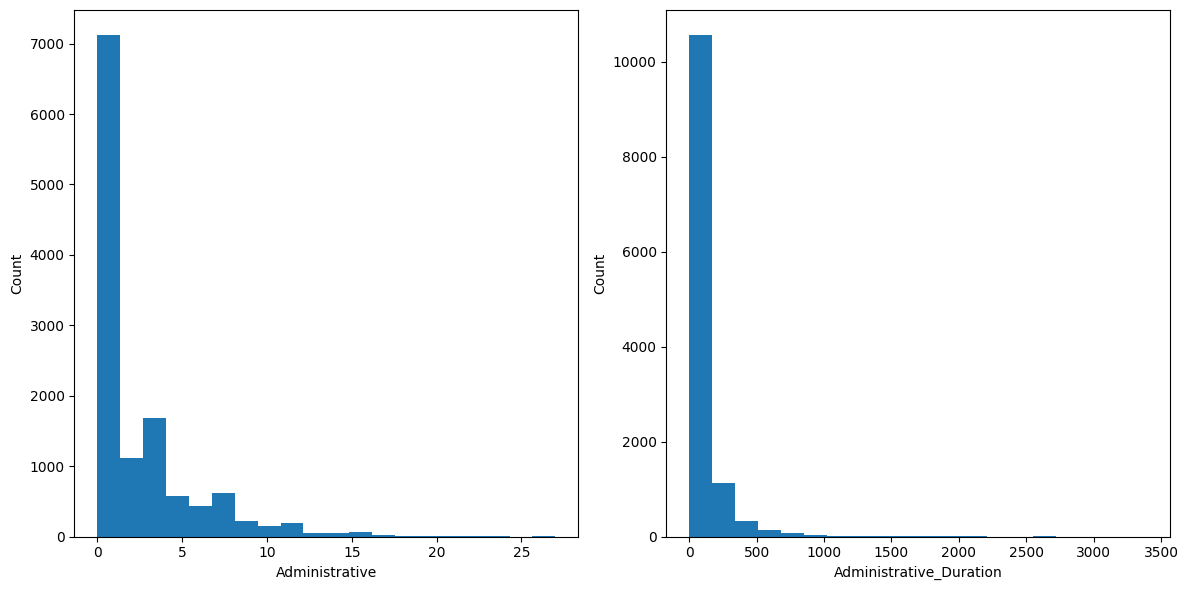

Administrative skew: 1.9603572090790138
Administrative_Duration skew: 5.61571901877419


In [562]:
plot_2_hist(data, 'Administrative', 'Administrative_Duration', 20)

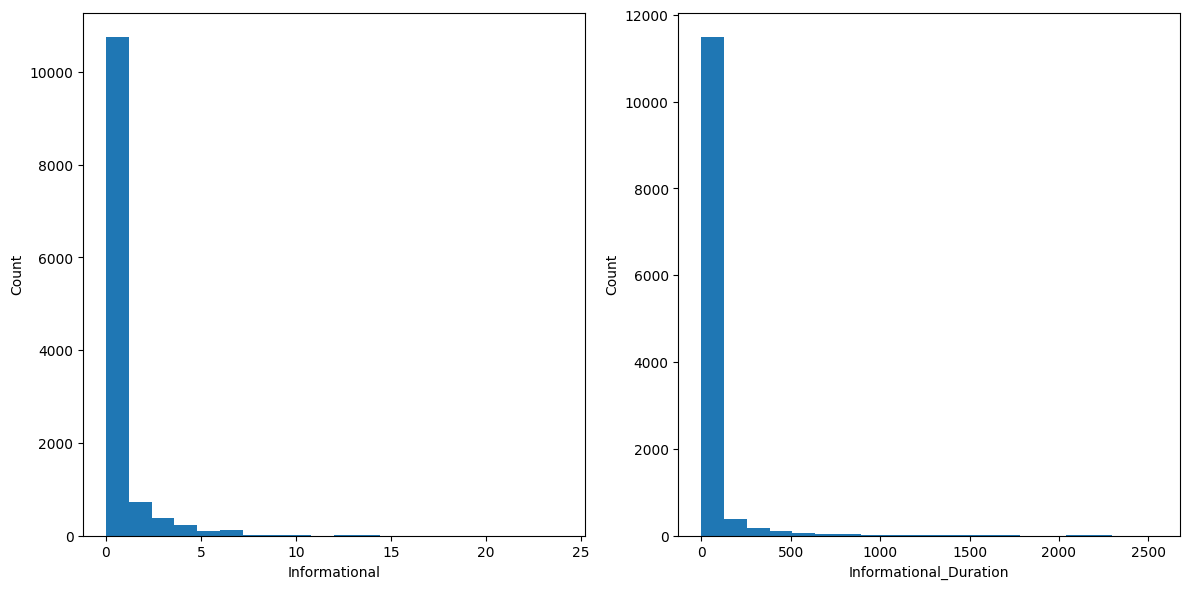

Informational skew: 4.036463759943139
Informational_Duration skew: 7.579184715734214


In [563]:
plot_2_hist(data, 'Informational', 'Informational_Duration', 20)

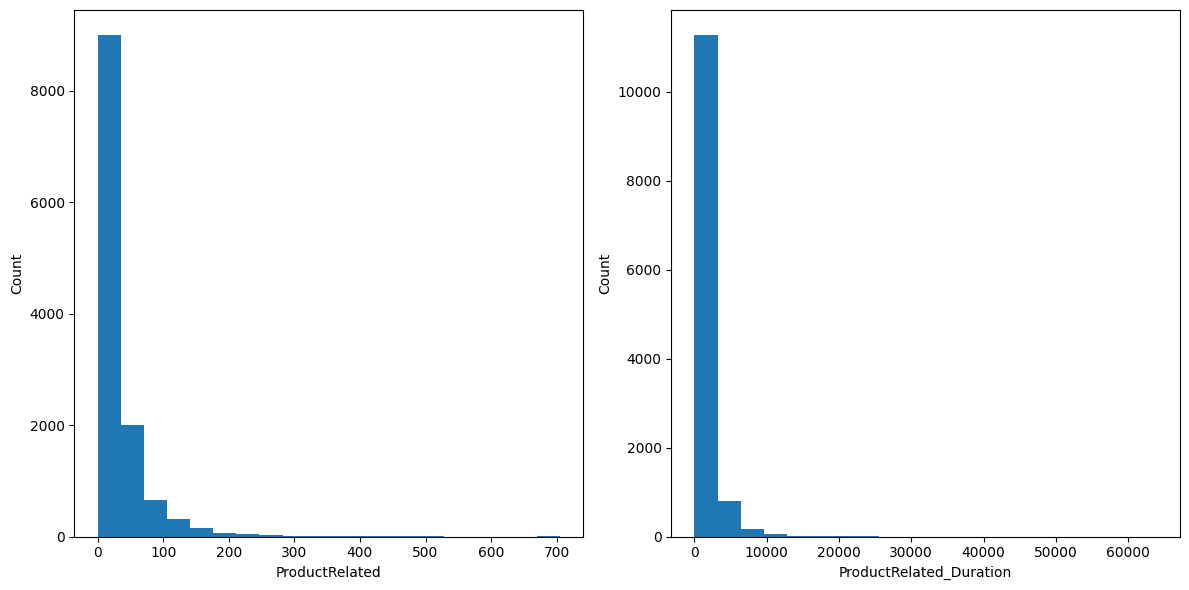

ProductRelated skew: 4.341516415550065
ProductRelated_Duration skew: 7.263227682561318


In [564]:
plot_2_hist(data, 'ProductRelated', 'ProductRelated_Duration', 20)

It can be seen that all of the columns have a heavy positive skew due to the large number of 0s in each column.

Because a large proportion of these columns are 0, logistic regression would likely be a poor method of modelling.  Some transformations could be used to adjust the data to be more normal, but there is not really anything that can be done for the high proportion of 0s.

One thing that I could try is splitting the columns into multiple features.  So there would be an is_zero column which is either a True or False.  The other column is the values if the column is not zero, otherwise it would be null.  The nulls are then filled in with some standard method for dealing with nulls when modelling such as filling them with the mean. 

### Page Behavior

There are 3 columns related to page behavior: BounceRates, ExitRates, PageValues.

BounceRates = "the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session."

ExitRates = "feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session."

PageValues = "the average value for a web page that a user visited before completing an e-commerce transaction."

In [565]:
def plot_hist(data, column, bins):
    data[column].hist(bins=bins)
    print(f"{column} skew: " + str(data[column].skew()))

BounceRates skew: 2.947855266695535


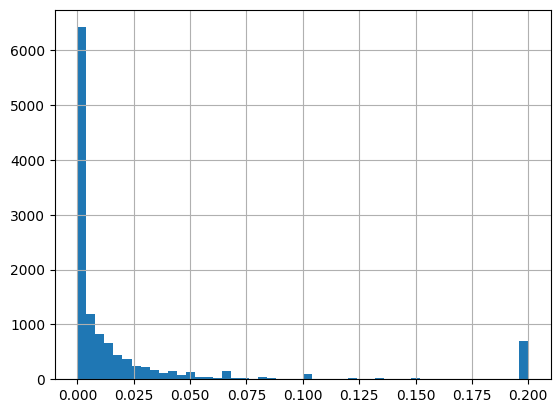

In [566]:
# plot distribution for Bounce rate
plot_hist(data, 'BounceRates', 50)

ExitRates skew: 2.1487889999009804


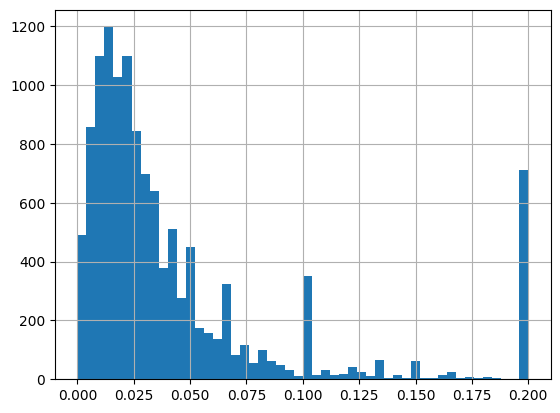

In [567]:
# plot distribution for Exit rate
plot_hist(data, 'ExitRates', 50)


In [568]:
print_column_correlation('BounceRates', 'ExitRates')

BounceRates, ExitRates correlation: 0.9130043961815202


Bounce rate and exit rate are highly correlated (>0.9) therefore only one of the columns will be used.  Exit rate has a better distribution, therefore it will be used and bounce rate will be dropped.

It is not exactly clear what Page value measures, but if it measures the pages visited until a purchase hase been made, there should only be values for users who have purchased something in the session or who are returning users who have already purchased something.

In [569]:
page_values = data.loc[data['PageValues'] != 0]
new_user_test = page_values.loc[(page_values['VisitorType'] == 'New_Visitor') & (page_values['Revenue'] is False)]
new_user_test

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue


The test has returned 0 rows, therefore it is safe to assume that this is the meaning of the column.
This column is not useful for the question being answered, but can be used to create a new column which indicates whether a user has bought something before.

### Date

There are 3 columns related to dates: SpecialDay, Month and Weekend.

SpecialDay = "indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction."

Month = the month in which the session took place

Weekend = boolean which indicates if a session occurred on the weekend

SpecialDay can be the discrete values: 0, 0.2, 0.4, 0.6, 0.8, 1 depending on how close a session is to a holiday.  1 is close to a holiday and 0 is not.

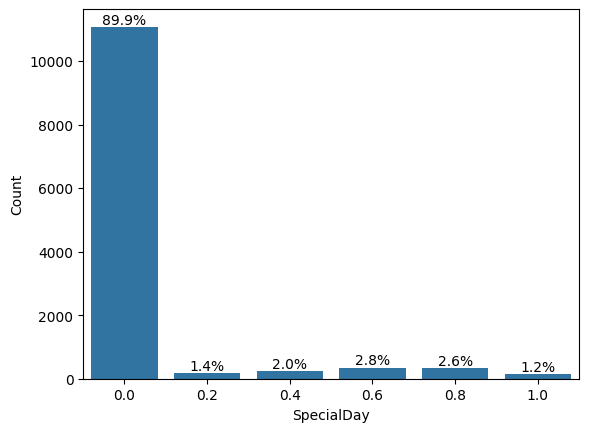

In [570]:
# plot distribution for special day
plot_bar(data, 'SpecialDay')

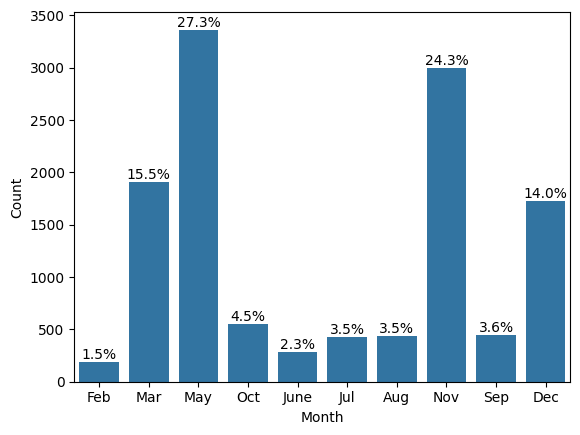

In [571]:
# plot distribution for month
plot_bar(data, 'Month')

There is not a uniform distribution of sessions across the year.

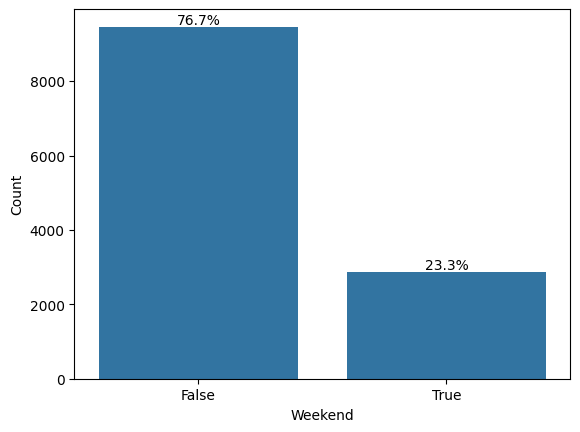

In [572]:
# plot distribution for weekend
plot_bar(data, 'Weekend')

There are less sessions on the weekend in the dataset.  This suggests that the number of sessions on week days and weekends are relatively similar as 5/7 = 71%.

### Visitor Characteristics

There are 5 columns related to visitor characteristics: OperatingSystems, Browser, Region, TrafficType, VisitorType.

The first 4 of these are unlikely to have an effect on the purchase prediction and can be excluded.  They are also already numerically encoded with no mapping available, making the information difficult to interpret.

VisitorType is useful and contains 'Returning_Visitor' or 'New_Visitor'.

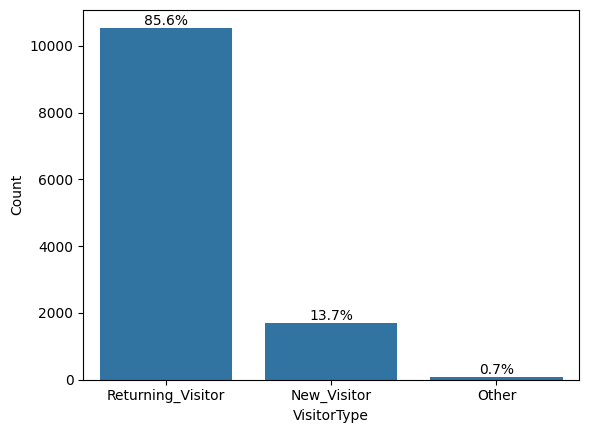

In [573]:
# plot distribution for visitor type
plot_bar(data, 'VisitorType')

Looking at the distribution, there is a third category called 'Other'.  It is not clear what this refers to, but it is only a small proportion of the data.

### Missing Data Check

Checking the data to see if there are any missing values.

In [574]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

The data does not appear to be missing anything.

## Feature Engineering

Order of changes made:
1. Drop unwanted columns
2. Generate new columns
3. Train, test split
4. Fill in nulls
5. Transformations
6. Category encoding
7. Scaling
8. Oversampling

Ordered in such a way to keep any models completely unaware of the test set.

### Drop Columns

Removing columns that I have no interest in (as defined in the initial investigation).

In [575]:
columns_to_drop = ['BounceRates', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
data = data.drop(columns_to_drop, axis=1)

### Split Columns

As mentioned before, I'm splitting the heavily skewed columns into multiple columns where one is flags if the value is 0 or not and the other contains not 0 values.

In [576]:
# Columns to split
skewed_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                        'ProductRelated', 'ProductRelated_Duration']
zero_columns = []
null_columns = []
for column in skewed_columns:
    # 0 flag columns
    zero_column_name = column + '_is_zero'
    data[zero_column_name] = np.where(data[column] == 0, 1, 0)
    zero_columns.append(zero_column_name)
    
    # Not 0 columns
    null_column_name = column + '_null'
    data[null_column_name] = np.where(data[column] == 0, None, data[column])
    null_columns.append(null_column_name)

print(zero_columns)
print(null_columns)

['Administrative_is_zero', 'Administrative_Duration_is_zero', 'Informational_is_zero', 'Informational_Duration_is_zero', 'ProductRelated_is_zero', 'ProductRelated_Duration_is_zero']
['Administrative_null', 'Administrative_Duration_null', 'Informational_null', 'Informational_Duration_null', 'ProductRelated_null', 'ProductRelated_Duration_null']


### Change Page Values Column

As mentioned in the data exploration section, page value refers to the time taken until a purchase has been made.  This is converted into 'PurchaseBefore' which is 1 when a returning user has bought something on a previous visit.  Otherwise, it will be 0 (always 0 for new visitors).

In [577]:
# Create and fill new column
data['PurchaseBefore'] = 0
data.loc[(data['PageValues'] != 0) & (data['VisitorType'] == 'Returning_Visitor'), 'PurchaseBefore'] = 1
print(data[['PageValues', 'VisitorType', 'PurchaseBefore']])
# Removing PageValues from the data as it is no longer needed
data = data.drop(['PageValues'], axis=1)

       PageValues        VisitorType  PurchaseBefore
0        0.000000  Returning_Visitor               0
1        0.000000  Returning_Visitor               0
2        0.000000  Returning_Visitor               0
3        0.000000  Returning_Visitor               0
4        0.000000  Returning_Visitor               0
...           ...                ...             ...
12325   12.241717  Returning_Visitor               1
12326    0.000000  Returning_Visitor               0
12327    0.000000  Returning_Visitor               0
12328    0.000000  Returning_Visitor               0
12329    0.000000        New_Visitor               0

[12330 rows x 3 columns]


### Train, Test Split

Splitting the data into a training and test set (30% of the data for testing).

In [578]:
y_name = 'Revenue'
X = data.loc[:, data.columns != y_name]
y = data[y_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Later I'm uses sklearn to transform the data, but also keep the original columns.  To do this I need to reset he indexes
X_train = X_train.reset_index()
X_test = X_test.reset_index()        

Checking that the split between each binary category is reasonable for the train and test sets.

In [579]:
y_train.value_counts()

Revenue
False    7298
True     1333
Name: count, dtype: int64

In [580]:
y_test.value_counts()

Revenue
False    3124
True      575
Name: count, dtype: int64

The splits are fine.  18% of the samples in train are purchase sessions and 18% in test.

### Fill in Nulls

Filling in the nulls generated in the previous split columns step with the column's mean.

In [581]:
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(X_train[null_columns])

imp_trans = ColumnTransformer(transformers=[('imp', SimpleImputer(strategy='mean'), null_columns)])
imp_trans.fit(X_train)

replace_columns_train = pd.DataFrame(imp_trans.transform(X_train), columns=null_columns)
X_train.update(replace_columns_train)

replace_columns_test = pd.DataFrame(imp_trans.transform(X_test), columns=null_columns)
X_test.update(replace_columns_test)

In [582]:
X_train.isnull().sum()

index                              0
Administrative                     0
Administrative_Duration            0
Informational                      0
Informational_Duration             0
ProductRelated                     0
ProductRelated_Duration            0
ExitRates                          0
SpecialDay                         0
Month                              0
VisitorType                        0
Weekend                            0
Administrative_is_zero             0
Administrative_null                0
Administrative_Duration_is_zero    0
Administrative_Duration_null       0
Informational_is_zero              0
Informational_null                 0
Informational_Duration_is_zero     0
Informational_Duration_null        0
ProductRelated_is_zero             0
ProductRelated_null                0
ProductRelated_Duration_is_zero    0
ProductRelated_Duration_null       0
PurchaseBefore                     0
dtype: int64

### Transformation

I'm also going to use sklearn's power transformer, to see if transforming the data has a positive effect on the logistic regression model.  This is done is such a way to keep the original columns.  This is separate from the previous splitting method.

In [583]:
def power_transform(transformer, df):
    transformed = transformer.transform(df)
    transformed = pd.DataFrame(data=transformed, columns=list(df.columns.values))
    transformed = transformed.add_suffix('_power')
    return transformed

In [584]:
# Create and fit power transformer
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
power_transformer.fit_transform(X_train[skewed_columns])
# Transform training set
train_transformed = power_transform(power_transformer, X_train[skewed_columns])

power_columns = list(train_transformed.columns.values)
train_transformed

,Administrative_power,Administrative_Duration_power,Informational_power,Informational_Duration_power,ProductRelated_power,ProductRelated_Duration_power
0,-0.992234,-0.997760,-0.520894,-0.491963,-0.988542,-1.000841
1,-0.992234,-0.997760,-0.520894,-0.491963,-1.344672,-0.626716
2,-0.992234,-0.997760,1.818108,2.076578,-0.629949,-0.164762
3,-0.992234,-0.997760,-0.520894,-0.491963,-1.344672,-2.121472
4,-0.992234,-0.997760,-0.520894,-0.491963,-1.148983,-1.569678
...,...,...,...,...,...,...
8626,1.725803,1.694581,-0.520894,-0.491963,0.320057,0.149277
8627,-0.992234,-0.997760,-0.520894,-0.491963,-0.174644,-0.319954
8628,-0.992234,-0.997760,-0.520894,-0.491963,-1.344672,-0.626716
8629,-0.992234,-0.997760,-0.520894,-0.491963,-0.236370,-0.379907


As can be seen from the plot below, the transformer has made the data more normally distributed, but of course the large proportion of 0s which are now -1s remain.

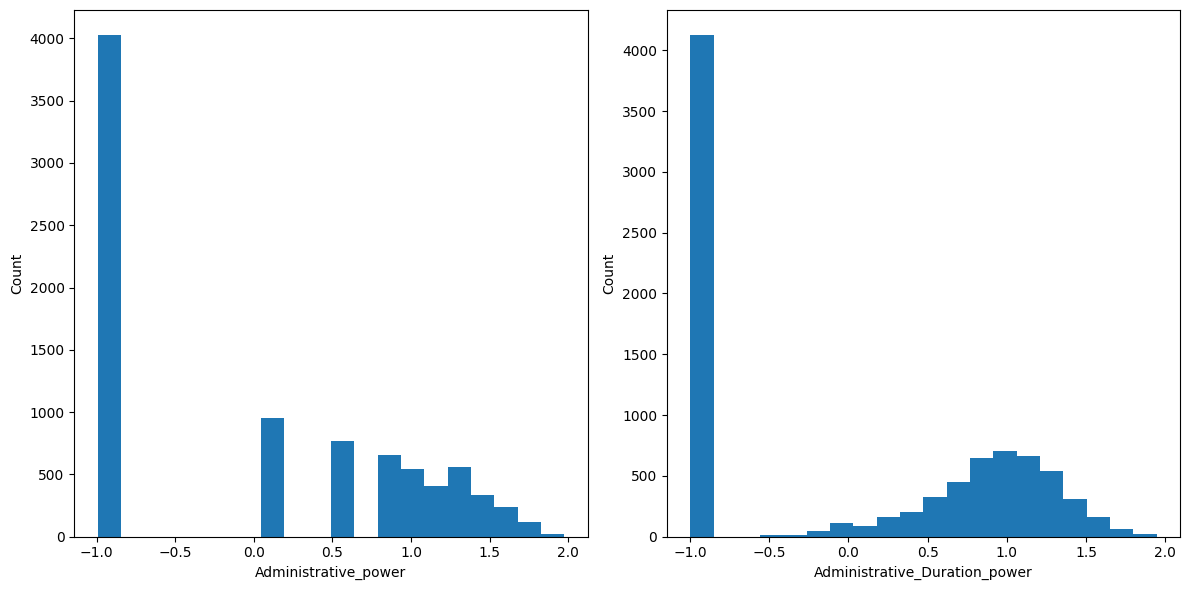

Administrative_power skew: 0.2401984799195235
Administrative_Duration_power skew: 0.14417600723096338


In [585]:
plot_2_hist(train_transformed, 'Administrative_power', 'Administrative_Duration_power', 20)

In [586]:
# Can merge because the transform maintains order (which is why I reset the indexes earlier)
X_train = X_train.merge(train_transformed, left_index=True, right_index=True)

# Repeat for test set, using the same transformer
test_transformed = power_transform(power_transformer, X_test[skewed_columns])
X_test = X_test.merge(test_transformed, left_index=True, right_index=True)


### Encoding Categories

The categorical input features are encoded using integer encoding.

In [587]:
# Class which allows the encoder to operate on multiple columns at once
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output
    
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [588]:
# Columns to encode
category_columns = ['Month', 'Weekend', 'VisitorType']
input_encoder = MultiColumnLabelEncoder(category_columns)
# Fit encoder and transform on the training set
X_train = input_encoder.fit_transform(X_train)
# Transform the test set
X_test = input_encoder.transform(X_test)

Creating another encoder which operates on the output (Revenue).

In [589]:
output_encoder = LabelEncoder().fit(y_train)
y_train = output_encoder.transform(y_train)
y_test = output_encoder.transform(y_test)

### Scaling

Scaling everything to be between 1 and 0 so that no columns dominate in any models because of their size.

In [590]:
# Fit scaler on training set and then transform
min_max_scaler = MinMaxScaler().fit(X_train)
X_train[X_train.columns] = pd.DataFrame(min_max_scaler.transform(X_train[X_train.columns]))
X_train = X_train.drop(['index'], axis=1)

# Scale the test set
X_test[X_test.columns] = pd.DataFrame(min_max_scaler.transform(X_test[X_test.columns]))
X_test = X_test.drop(['index'], axis=1)


In [591]:
X_test

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,ExitRates,SpecialDay,Month,VisitorType,...,ProductRelated_null,ProductRelated_Duration_is_zero,ProductRelated_Duration_null,PurchaseBefore,Administrative_power,Administrative_Duration_power,Informational_power,Informational_Duration_power,ProductRelated_power,ProductRelated_Duration_power
0,0.111111,0.052380,0.000000,0.000000,0.068085,0.024374,0.065217,0.0,0.777778,1.0,...,0.066761,0.0,0.024351,0.0,0.620286,0.719721,0.000000,0.000000,0.579808,0.372207
1,0.222222,0.160776,0.083333,0.107297,0.117730,0.057999,0.024581,0.0,0.555556,1.0,...,0.116477,0.0,0.057977,1.0,0.770103,0.836327,0.984314,0.997803,0.663175,0.474886
2,0.037037,0.015117,0.000000,0.000000,0.178723,0.099835,0.064114,0.0,0.777778,1.0,...,0.177557,0.0,0.099814,1.0,0.364405,0.575097,0.000000,0.000000,0.727630,0.550454
3,0.074074,0.051829,0.000000,0.000000,0.014184,0.014053,0.131944,0.0,0.000000,1.0,...,0.012784,0.0,0.014030,1.0,0.524931,0.718558,0.000000,0.000000,0.352696,0.316856
4,0.666667,0.223540,0.250000,0.334260,0.238298,0.114623,0.067638,0.0,0.000000,1.0,...,0.237216,0.0,0.114602,1.0,0.951096,0.868161,0.999368,0.999518,0.772445,0.571226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,0.000000,0.000000,0.000000,0.000000,0.017021,0.026993,0.215278,0.0,0.555556,1.0,...,0.015625,0.0,0.026971,0.0,0.000000,0.000000,0.000000,0.000000,0.377807,0.383260
3695,0.074074,0.012939,0.083333,0.045005,0.119149,0.193777,0.186047,0.0,1.000000,1.0,...,0.117898,0.0,0.193759,0.0,0.524931,0.555893,0.984314,0.993979,0.665014,0.656482
3696,0.000000,0.000000,0.000000,0.000000,0.014184,0.004552,0.333333,0.6,0.666667,1.0,...,0.012784,0.0,0.004529,0.0,0.000000,0.000000,0.000000,0.000000,0.352696,0.223326
3697,0.037037,0.008528,0.000000,0.000000,0.042553,0.022340,0.017857,0.0,0.888889,0.0,...,0.041193,0.0,0.022318,0.0,0.364405,0.503372,0.000000,0.000000,0.509593,0.362977


### Oversampling

There are far less sessions that contain a purchase than those that don't.  To account for this, naive oversampling is used on the training set to have equal samples for each class.

In [592]:
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

Have gone from 8,631 training samples to 14,596.  There are now an equal number of each class (7298 for both).

In [593]:
y_train_df = pd.DataFrame(y_train)
y_train_df.value_counts()

0
0    7298
1    7298
Name: count, dtype: int64

## Modeling and Analysis

Set 1 = Regular

In [594]:
set_1_train = X_train[X_train.columns[~X_train.columns.isin(zero_columns + null_columns + power_columns)]]
set_1_test = X_test[X_test.columns[~X_test.columns.isin(zero_columns + null_columns + power_columns)]]
set_1_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,ExitRates,SpecialDay,Month,VisitorType,Weekend,PurchaseBefore
0,0.000000,0.000000,0.000000,0.000000,0.007092,0.001878,0.250000,0.0,0.111111,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.004255,0.004378,0.333333,0.0,0.555556,1.0,0.0,0.0
2,0.000000,0.000000,0.041667,0.060128,0.011348,0.010308,0.071429,0.0,0.555556,1.0,1.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.004255,0.000000,1.000000,0.0,0.555556,1.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.005674,0.000324,0.750000,0.0,0.555556,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14591,0.111111,0.117405,0.041667,0.114700,0.075177,0.058495,0.053030,0.0,0.333333,1.0,0.0,1.0
14592,0.407407,0.283745,0.083333,0.097557,0.055319,0.023684,0.061806,0.0,0.666667,1.0,0.0,1.0
14593,0.000000,0.000000,0.083333,0.022093,0.083688,0.050851,0.153005,0.0,0.777778,1.0,0.0,0.0
14594,0.074074,0.010292,0.000000,0.000000,0.072340,0.059942,0.037173,0.0,0.777778,1.0,0.0,1.0


Set 2 = Power Transformed

In [595]:
set_2_train = X_train[X_train.columns[~X_train.columns.isin(skewed_columns + zero_columns + null_columns)]]
set_2_test = X_test[X_test.columns[~X_test.columns.isin(skewed_columns + zero_columns + null_columns)]]
set_2_train

,ExitRates,SpecialDay,Month,VisitorType,Weekend,PurchaseBefore,Administrative_power,Administrative_Duration_power,Informational_power,Informational_Duration_power,ProductRelated_power,ProductRelated_Duration_power
0,0.250000,0.0,0.111111,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.262180,0.165322
1,0.333333,0.0,0.555556,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.202150,0.220515
2,0.071429,0.0,0.555556,1.0,1.0,0.0,0.000000,0.000000,0.927297,0.995670,0.322626,0.288665
3,1.000000,0.0,0.555556,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.202150,0.000000
4,0.750000,0.0,0.555556,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.235136,0.081404
...,...,...,...,...,...,...,...,...,...,...,...,...
14591,0.053030,0.0,0.333333,1.0,0.0,1.0,0.620286,0.804949,0.927297,0.997972,0.594780,0.476000
14592,0.061806,0.0,0.666667,1.0,0.0,1.0,0.879113,0.890536,0.984314,0.997538,0.548617,0.369144
14593,0.153005,0.0,0.777778,1.0,0.0,0.0,0.000000,0.000000,0.984314,0.986707,0.611043,0.457959
14594,0.037173,0.0,0.777778,1.0,0.0,1.0,0.524931,0.527244,0.000000,0.000000,0.588962,0.479207


Set 3 = Split

In [596]:
set_3_train = X_train[X_train.columns[~X_train.columns.isin(skewed_columns + power_columns)]]
set_3_test = X_test[X_test.columns[~X_test.columns.isin(skewed_columns + power_columns)]]
set_3_train

,ExitRates,SpecialDay,Month,VisitorType,Weekend,Administrative_is_zero,Administrative_null,Administrative_Duration_is_zero,Administrative_Duration_null,Informational_is_zero,Informational_null,Informational_Duration_is_zero,Informational_Duration_null,ProductRelated_is_zero,ProductRelated_null,ProductRelated_Duration_is_zero,ProductRelated_Duration_null,PurchaseBefore
0,0.250000,0.0,0.111111,0.0,0.0,1.0,0.127548,1.0,0.056235,1.0,0.060054,1.0,0.079647,0.0,0.005682,0.0,0.001855,0.0
1,0.333333,0.0,0.555556,1.0,0.0,1.0,0.127548,1.0,0.056235,1.0,0.060054,1.0,0.079647,0.0,0.002841,0.0,0.004355,0.0
2,0.071429,0.0,0.555556,1.0,1.0,1.0,0.127548,1.0,0.056235,0.0,0.000000,0.0,0.059700,0.0,0.009943,0.0,0.010285,0.0
3,1.000000,0.0,0.555556,1.0,0.0,1.0,0.127548,1.0,0.056235,1.0,0.060054,1.0,0.079647,0.0,0.002841,1.0,0.029363,0.0
4,0.750000,0.0,0.555556,1.0,0.0,1.0,0.127548,1.0,0.056235,1.0,0.060054,1.0,0.079647,0.0,0.004261,0.0,0.000301,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14591,0.053030,0.0,0.333333,1.0,0.0,0.0,0.076923,0.0,0.116972,0.0,0.000000,0.0,0.114296,0.0,0.073864,0.0,0.058473,1.0
14592,0.061806,0.0,0.666667,1.0,0.0,0.0,0.384615,0.0,0.283394,0.0,0.043478,0.0,0.097146,0.0,0.053977,0.0,0.023662,1.0
14593,0.153005,0.0,0.777778,1.0,0.0,1.0,0.127548,1.0,0.056235,0.0,0.043478,0.0,0.021647,0.0,0.082386,0.0,0.050829,0.0
14594,0.037173,0.0,0.777778,1.0,0.0,0.0,0.038462,0.0,0.009807,1.0,0.060054,1.0,0.079647,0.0,0.071023,0.0,0.059920,1.0


### Model 1 - Logistic Regression

### Model 2 - Decision Tree